In [ ]:
!mkdir -p "generator_models_fashion_mnist_tutorial/gan"

In [ ]:
!wget -c "https://drive.usercontent.google.com/download?id=1zpqUpXIa77sgsc6CgTc0CLIEVnIuc83B&export=download&authuser=2&confirm=yes" -O "./generator_final.pth"

--2024-12-05 13:46:26--  https://drive.usercontent.google.com/download?id=1zpqUpXIa77sgsc6CgTc0CLIEVnIuc83B&export=download&authuser=2&confirm=yes
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.137.132, 2607:f8b0:4023:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.137.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6065932 (5.8M) [application/octet-stream]
Saving to: ‘./generator_final.pth’

./generator_final.p 100%[===================>]   5.78M  31.5MB/s    in 0.2s    

2024-12-05 13:46:31 (31.5 MB/s) - ‘./generator_final.pth’ saved [6065932/6065932]



In [ ]:
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.autograd import Variable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.autograd import Variable
from PIL import Image
import cv2
from google.colab import drive
import os

TRAIN_NEW_MODEL = True
trained_model_path = "./generator_final.pth"
output_folder = "generator_models_fashion_mnist_tutorial/gan"

# Generative Adversarial Networks (GAN) - PyTorch Tutorial

The goal of this notebook is to implement a GAN using `PyTorch`.

By the end of this tutorial, we will have a model capable of generating the *Synthetic* data samples of the image below.


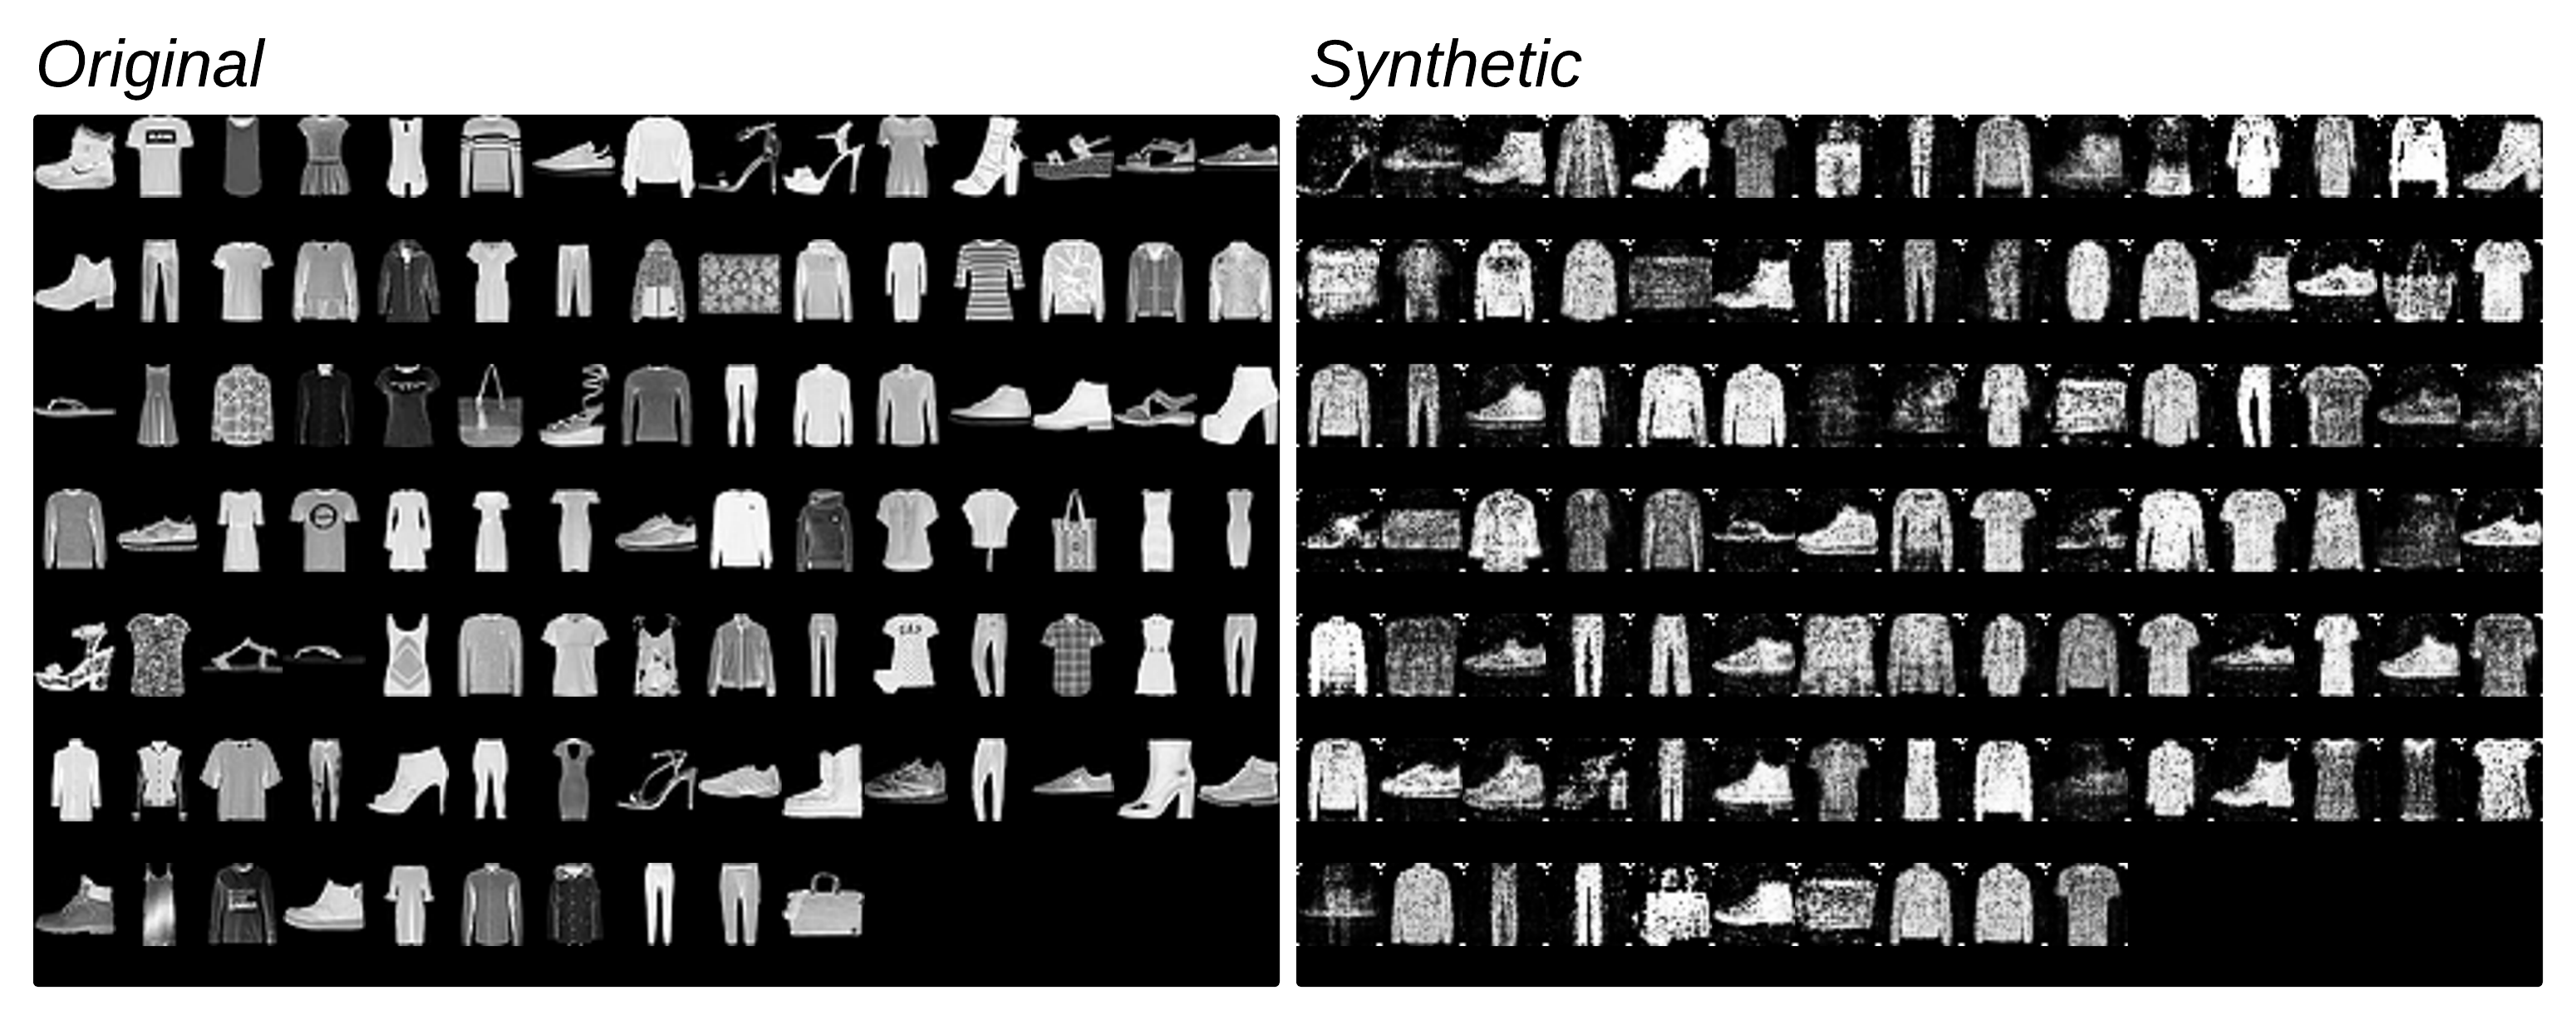

## 1. Dataset Loading

We will begin by loading the FashionMNIST dataset from `torchvision`, which is a package that "consists of popular datasets, model architectures, and common image transformations for computer vision". For each data sample of the dataset, we will apply two transformations described below.

### Data Transformations

- `ToTensor`: this transformation converts a `PIL` image or `numpy` array with shape $\text{(Height x Width x Channels)}$ in the range $[0,255]$ to a `torch.FloatTensor` of shape $\text{(Channels x Height x Width)}$ in the range $[0,1]$
- `Normalize`: subtracts a constant value from each pixel and divides the result by another constant. The values to subtract and divide the pixels were chosen so that the resulting images will be in the range $[-1,1]$. We will use:
 \begin{align} \text{normalized_pixel} &= \frac{(\text{pixel} - c_1)}{c_2}. \\
                                        c_1 &= 0.5 \\
                                        c_2 &= 0.5
\end{align}

After such transformations we all of the dataset tensor's values will be in the range $[-1,1]$. Such range is desirable for training stability and some activations functions like the `tanh` that naturally output values in this range.

In [ ]:
dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose(
                           [transforms.ToTensor(),
                            transforms.Normalize([0.5],[0.5])]),
    target_transform=transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

batch_size = 64
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)


temp_img, _ =  dataset.__getitem__(0)
print(f"Image Size: {temp_img.size()}")
print(f"Image range: {temp_img.max(), temp_img.min()}")

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.6MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.71MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.71MB/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Image Size: torch.Size([1, 28, 28])
Image range: (tensor(1.), tensor(-1.))


### 2. Generator Definition

Our generator will have a total of $4$ hidden layers. Each of such hidden layers is composed the following parts:

**Hidden Layer:**
- `Linear`: the traditional linear function that have weights that multiplies the layer's inputs and sums the result to a bias
- `BatchNorm1d`: a normalization function that normalizes each activation's output by averaging such output among the samples in a mini-batch. This technique makes the training faster and less influenced by the initial conditions of the learning procedure. Such techniques also keeps a moving average for each neuron's output value that is used during inference time and that is calulated using a `momentum` that defines the weight of past averages relatively to the new one.

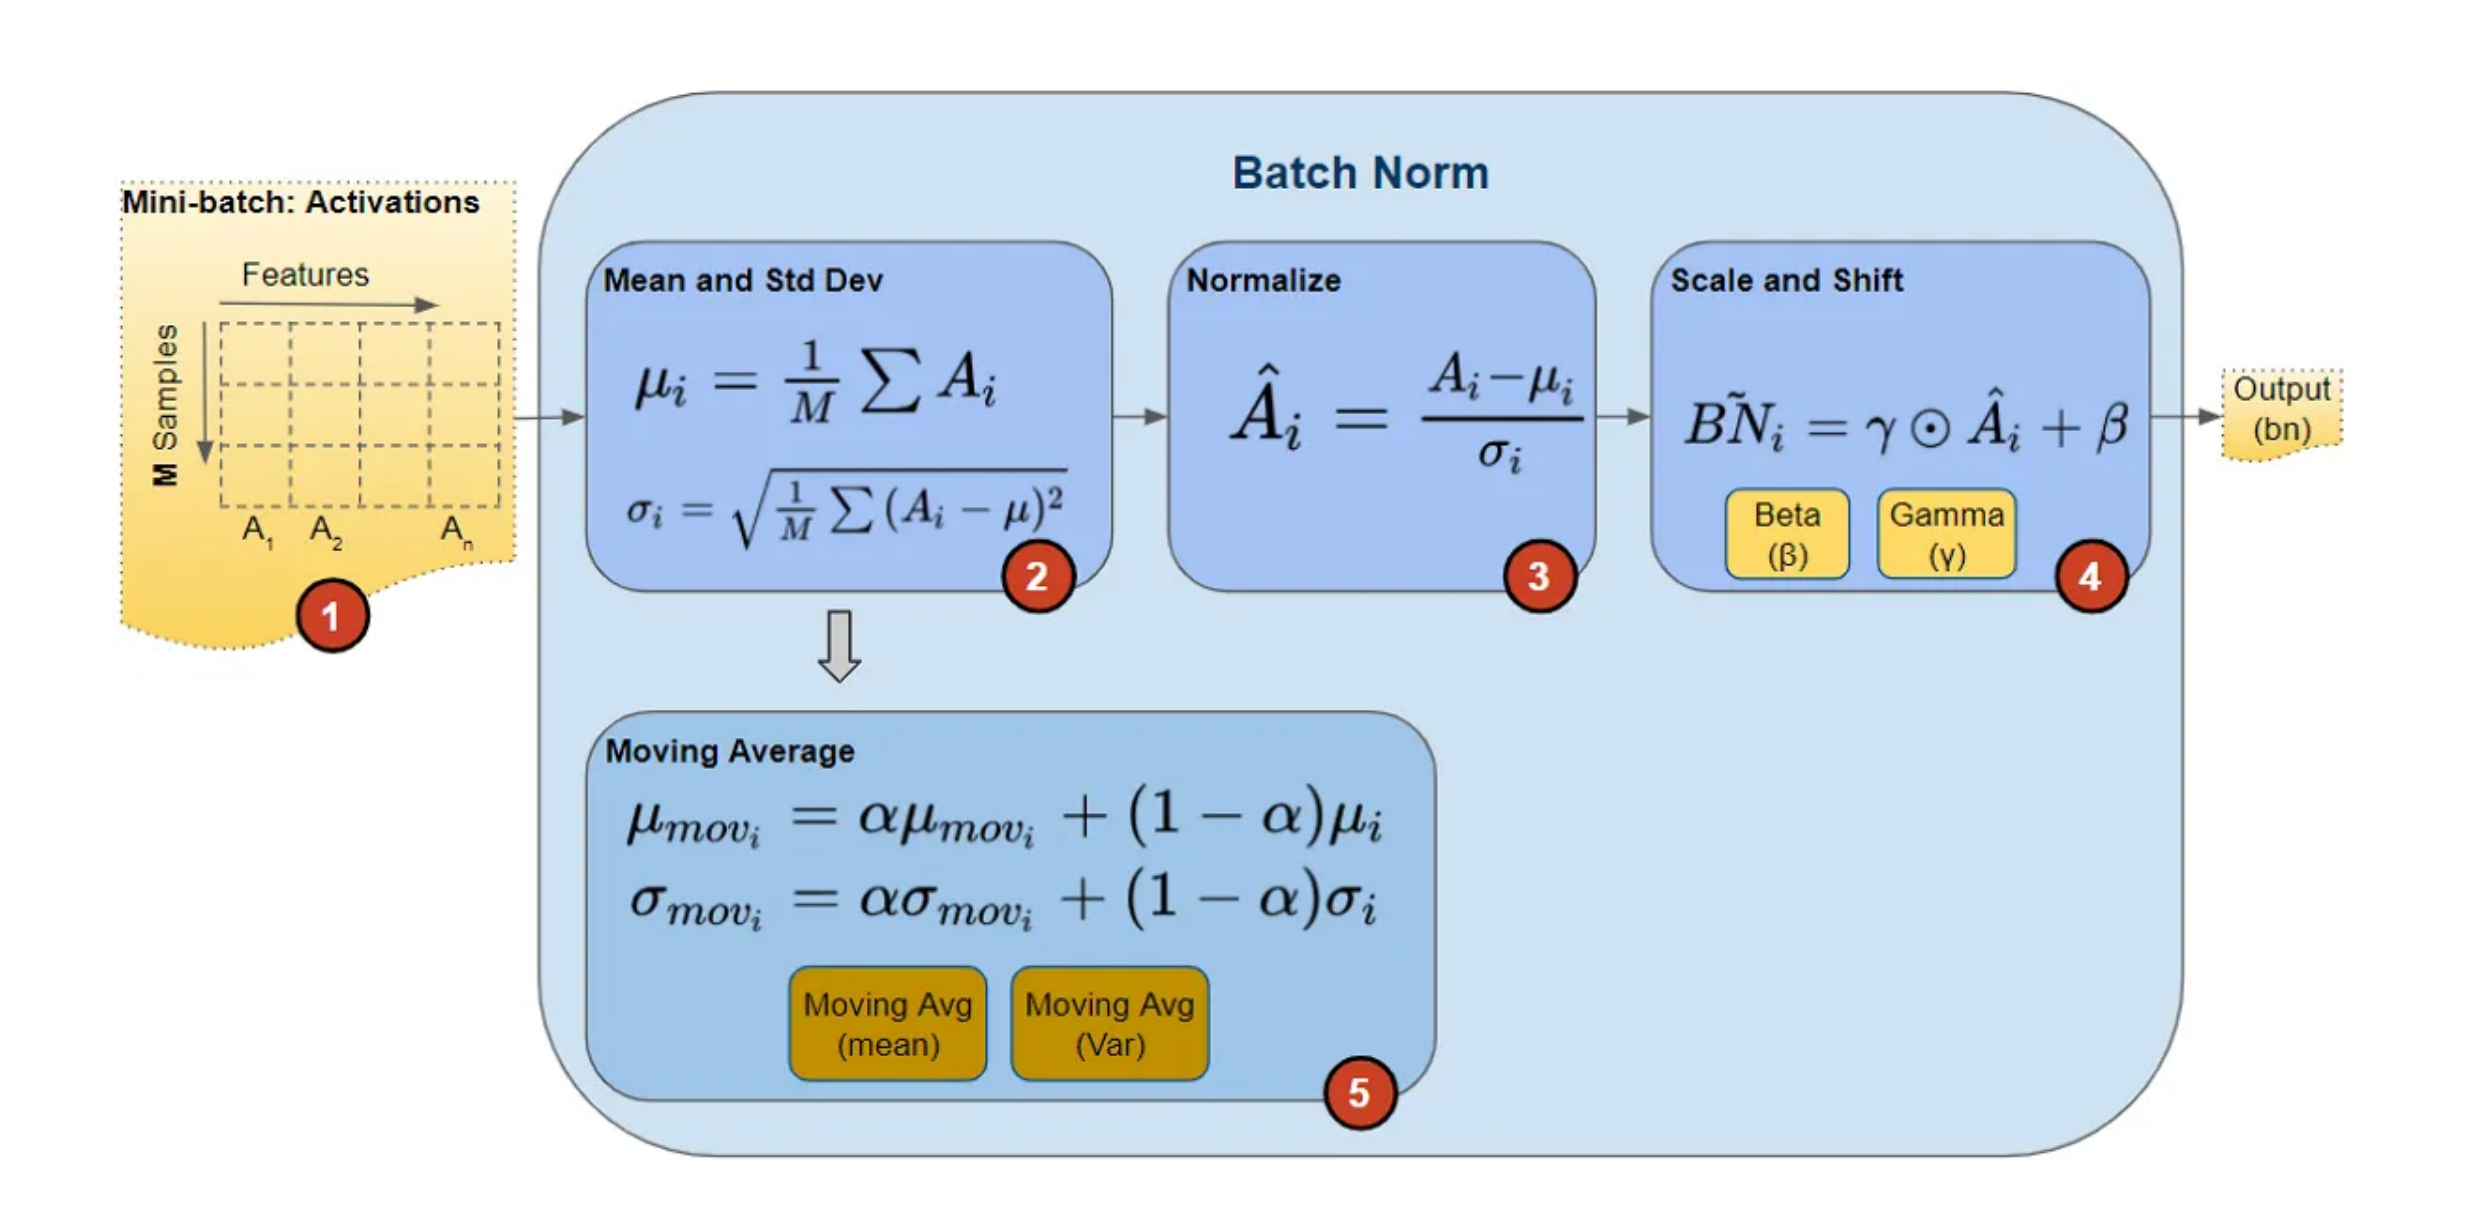
<p align="left">  <i> Image Extracted from the Medium Towards Data Science post: "Batch Norm Explained Visually — How it works, and why neural networks need it" </i> </p>


- `LeakyReLU`: the Leaky Rectified Linear Unit is an activation function based on the traditional ReLU. The former has a small slope for negative values instead of a zeroed one as in the latter. This avoids problems like dead neurons, improves gradient flow and training stability, which are common issues faced when training GANs.


The output layers will output $28 x 28$ images such that it is made of:

**Output Layer:**
- `Linear`: the last network's linear layer is responsible for transforming the last hidden layer's activation function output to the output space ($28 x 28$)
- `Tanh`: the Hyperbolic Tangent is used as the ouput layer's activation function, which is a function that outputs values in the range $[-1, 1]$ - the same range that the inputs are cast to when preprocessed. This way, using tanh ensures that the outputs are generated in the desired range.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        latent_dim = 100
        channels = 1
        img_size = 28
        self.img_shape = (channels, img_size, img_size)

        # The momentum parameter is used to update the running mean and variance of the batch normalization layers
        momentum = 0.8

        # First layer: Linear transformation
        self.fc1 = nn.Linear(latent_dim, 128)
        self.bn1 = nn.BatchNorm1d(128, momentum = momentum)
        self.relu1 = nn.LeakyReLU(0.2, inplace=True) #inplace=True means that relu it will modify the input directly,
                                                     #without allocating any additional memory for the output

        # Second layer: Linear transformation
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256, momentum = momentum)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)

        # Third layer: Linear transformation
        self.fc3 = nn.Linear(256, 512)
        self.bn3 = nn.BatchNorm1d(512, momentum = momentum)
        self.relu3 = nn.LeakyReLU(0.2, inplace=True)

        # Fourth layer: Linear transformation
        self.fc4 = nn.Linear(512, 1024)
        self.bn4 = nn.BatchNorm1d(1024, momentum = momentum)
        self.relu4 = nn.LeakyReLU(0.2, inplace=True)

        # Output layer: Linear transformation
        self.fc5 = nn.Linear(1024, int(np.prod(self.img_shape)))
        self.tanh = nn.Tanh()

    def forward(self, z):
        # Apply first layer
        x = self.fc1(z)
        x = self.bn1(x)
        x = self.relu1(x)

        # Apply second layer
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        # Apply third layer
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        # Apply fourth layer
        x = self.fc4(x)
        x = self.bn4(x)
        x = self.relu4(x)

        # Apply output layer
        x = self.fc5(x)
        img = self.tanh(x)

        # Reshape the output to the desired image shape
        img = img.view(img.size(0), *self.img_shape)
        return img

### 3. Discriminator Definition

Our Discriminator will have $2$ hidden layers that have the same components as the generator's ones.

The Discriminator's output layer, on the other hand, will use `Sigmoid` as its activation function, because we want it to output values in the range $[0,1]$ that will serve as a proxy for the probability of a generator's output to be considered real.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        channels = 1
        img_size = 28
        self.img_shape = (channels, img_size, img_size)
        momentum = 0.8
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(self.img_shape)), 512),
            nn.BatchNorm1d(512, momentum=momentum),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256, momentum=momentum),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1) #flatten -> from (64, 1, 28, 28) to (64, 1*28*28)
        validity = self.model(img_flat) # Discriminate -> Real? or Fake? (64, 784) -> (64, 1)
        return validity

### 4. Adversarial Loss and Optimizers Definition

For both the generator and discriminator, the **Binary Cross-Entropy** will be used as the Adversarial Loss function:
- `BCELoss`: it is commonly used for binary classification tasks as it measures the difference between the predicted probability by a model and the actual label of a sample (or a batch of samples)
    - **Generator Loss** : we are interested in minimizing the difference between the discriminator's prediction on the generator output and the corresponding discriminator output for "real". In other words, we want the generator to learn how to fool the discriminator such that the latter predicts "real" for the former's output.
    - **Discriminator Loss** : we are interested in both minimizing the difference between its output for fake data and the corresponding value for fake; and the difference between its output for real data and the corresponding value for "real".

For both the generator and discriminator, the **Adam Optimizer** will be used as the optimization algorithm for gradient descent.

In [ ]:
generator = Generator()
discriminator = Discriminator()
adversarial_loss = torch.nn.BCELoss()

b1 = 0.5
b2 = 0.999
learning_rate = 0.0002
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(b1,b2))
discriminator_optimizer= torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(b1,b2))

In [ ]:
generator

Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.2, inplace=True)
  (fc4): Linear(in_features=512, out_features=1024, bias=True)
  (bn4): BatchNorm1d(1024, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.2, inplace=True)
  (fc5): Linear(in_features=1024, out_features=784, bias=True)
  (tanh): Tanh()
)

In [ ]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=256, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

### 5. Training

For each batch, the training of the generator and discriminator are done separately so that both are updated independently by the end of each batch.

  0%|          | 0/938 [00:00<?, ?it/s]

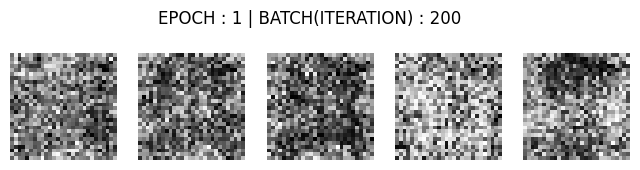

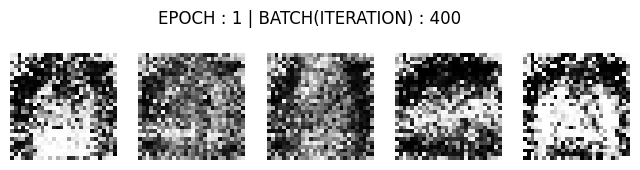

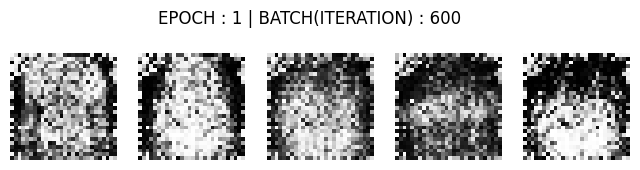

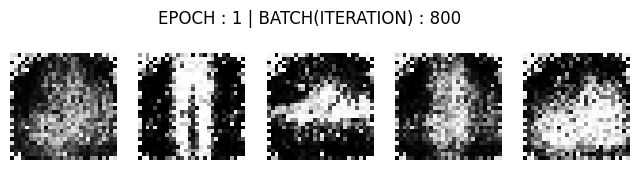

[Epoch: 1/4] [Batch: 938/938] [D loss: 0.564298] [G loss: 0.941955]


  0%|          | 0/938 [00:00<?, ?it/s]

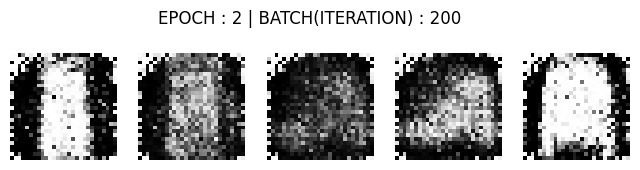

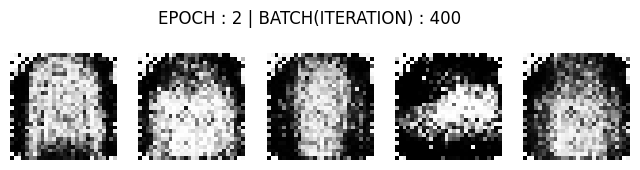

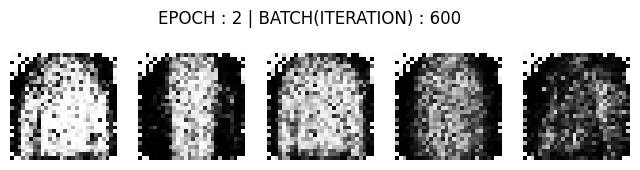

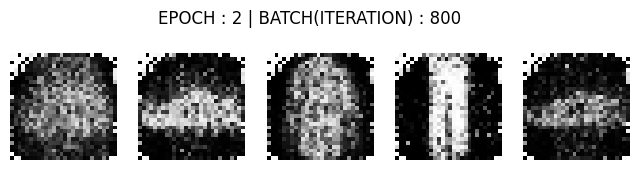

[Epoch: 2/4] [Batch: 938/938] [D loss: 0.661482] [G loss: 0.860677]


  0%|          | 0/938 [00:00<?, ?it/s]

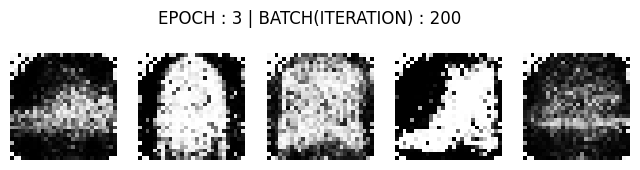

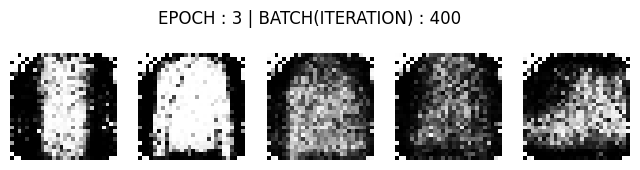

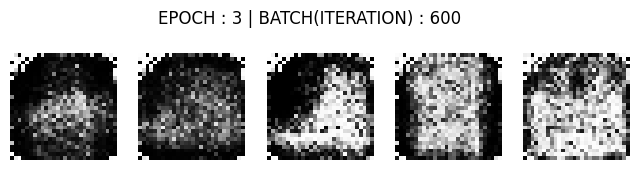

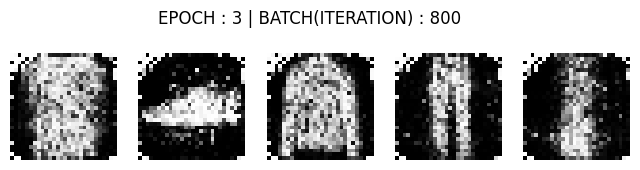

[Epoch: 3/4] [Batch: 938/938] [D loss: 0.625817] [G loss: 0.878217]


  0%|          | 0/938 [00:00<?, ?it/s]

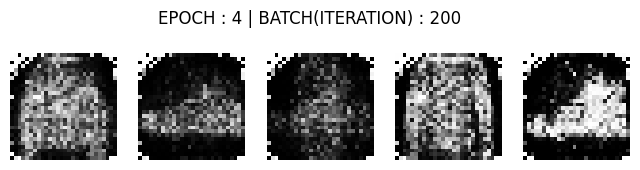

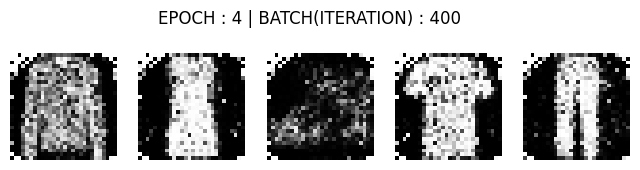

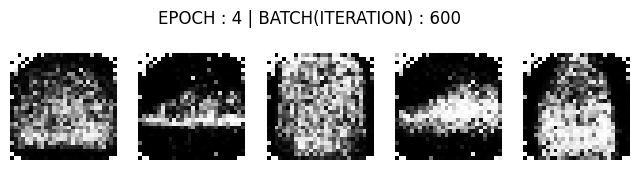

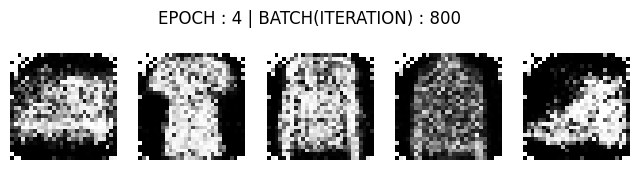

[Epoch: 4/4] [Batch: 938/938] [D loss: 0.625527] [G loss: 0.847095]


In [ ]:
if TRAIN_NEW_MODEL:
  if torch.cuda.is_available():
      generator.cuda()
      discriminator.cuda()
      adversarial_loss.cuda()
      Tensor = torch.cuda.FloatTensor
  else:
      Tensor = torch.FloatTensor

  n_epochs = 4
  latent_dim = 100
  for epoch in range(n_epochs):
      for i, (imgs, _) in enumerate(tqdm(dataloader)):

          # We need to create a tensor of ones and zeros to use as labels for the real and fake images.
          # Such tensor must have as many elements as the batch size of the real images.
          valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
          fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

          real_imgs = imgs.type(Tensor)

      # ------------
      # Train Generator
      # ------------
          generator_optimizer.zero_grad()

          # sample noise 'z' as generator input
          z = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim))) # Random sampling Tensor(batch_size, latent_dim) of Gaussian distribution

          # Generate a batch of images
          gen_imgs = generator(z)

          # Loss measures generator's ability to fool the discriminator
          g_loss = adversarial_loss(discriminator(gen_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)

          g_loss.backward()
          generator_optimizer.step()

  # ------------
  # Train Discriminator
  # ------------
          discriminator_optimizer.zero_grad()

          # Measure discriminator's ability to classify real from generated samples
          real_loss = adversarial_loss(discriminator(real_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)
          fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake) # We are learning the discriminator now. So have to use detach()

          d_loss = (real_loss + fake_loss) / 2

          d_loss.backward()# If didn't use detach() for gen_imgs, all weights of the generator will be calculated with backward().
          discriminator_optimizer.step()

  # ------------
  # Real Time Visualization (While Training)
  # ------------

          sample_z_in_train = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
          sample_gen_imgs_in_train = generator(sample_z_in_train).detach().cpu()

          if ((i+1) % 200) == 0: # show while batch - 200/657, 400/657, 600/657
              nrow=1
              ncols=5
              fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(8,2))
              plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, i+1))
              for ncol in range(ncols):
                  axes[ncol].imshow(sample_gen_imgs_in_train.permute(0,2,3,1)[ncol], cmap='gray')
                  axes[ncol].axis('off')
              plt.show()
      print(
          "[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
          % (epoch+1, n_epochs, i+1, len(dataloader), d_loss.item(), g_loss.item())
      )

  os.makedirs(output_folder, exist_ok=True)
  torch.save(generator.state_dict(), os.path.join(output_folder, "fashion_mnist_gan.pth"))
  torch.save(discriminator.state_dict(),os.path.join(output_folder, "discriminator_fashion_mnist.pth"))
  torch.save(generator_optimizer.state_dict(), os.path.join(output_folder, "generator_optimizer_final.pth"))
  torch.save(discriminator_optimizer.state_dict(), os.path.join(output_folder, "discriminator_optimizer_final.pth"))

### 6. Visualizing the Generator's Outputs

In [ ]:
generator = Generator()
generator.load_state_dict(torch.load(trained_model_path))

def generate_and_display_images(generator: Generator,
                                cell_width: float,
                                cell_height: float,
                                num_images: int = 5,
                                latent_dim: int =100) -> Image:

    # Generate random noise vectors
    z = torch.randn(num_images, latent_dim)
    # Generate images from the noise vectors

    n_cols = 15
    gen_imgs = generator(z).detach().cpu()
    n_rows = num_images // n_cols + (1 if num_images % n_cols != 0 else 0)

    full_img = Image.new("RGB", (n_cols * cell_width, n_rows * cell_height))

    def tensor_to_numpy(img):
        img = img.view(28, 28).numpy()
        rescaled_img = cv2.normalize(img, None, alpha=0, beta=255, norm_type = cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        return rescaled_img

    for i, img in enumerate(gen_imgs):
        img = tensor_to_numpy(img)
        img = Image.fromarray(img)
        if img.width > img.height:
            img = img.transpose(method=Image.Transpose.ROTATE_270)

        prop = img.width / img.height

        col = i % n_cols
        row = i // n_cols

        x = col * cell_width
        y = row * cell_height

        new_width = cell_width
        new_height = int(cell_width / prop)
        img = img.resize((new_width, new_height))
        full_img.paste(img, (x, y))

    return full_img

<ipython-input-11-5ba22161a4ef>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(trained_model_path))


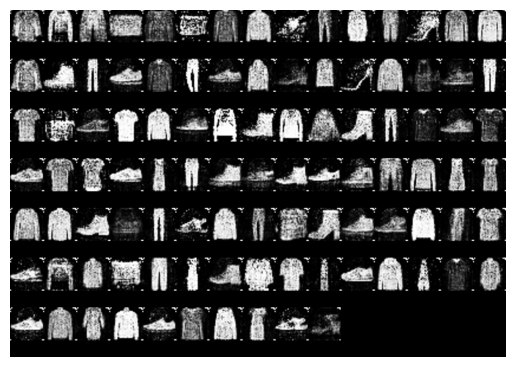

In [ ]:
img = generate_and_display_images(generator, cell_width=100,cell_height=150, num_images=100, latent_dim=100)
plt.imshow(img, cmap='gray')

plt.axis('off')
plt.show()